In [1]:
!pip install wget
!pip install transformers

# BERT Fine Tuning for Multi Class Text Classification 

This notebook contains code to fine tune a pretrained BERT language model to a specific classification task. 
As BERT model interface the Huggingface library with a PyTorch backend is used.

In this notebook, the model has been fine tuned with the German 10kGNAD Dataset but could easily be fine tuned on any other classification dataset.

The code was implemented based on the huggingface example scripts for glue tasks fine tuning (https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128) and the blog post by Chris McCormick (http://mccormickml.com/2019/07/22/BERT-fine-tuning/).


In [2]:
import os
import time
import datetime
import random
from google.colab import drive

import pandas as pd
import numpy as np
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import AdamW
from transformers import AutoTokenizer
from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import IPython

import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Empty cache of GPU
torch.cuda.empty_cache()

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## Load data

In [0]:
# Download dataset
df = pd.read_csv("https://raw.githubusercontent.com/tblock/10kGNAD/master/articles.csv",
                 encoding="utf-8",
                 delimiter=";",
                 quotechar="'", names=["label","text"])

In [0]:
texts = df.text.values
label_cats = df.label.astype('category').cat

# List of label names (str)
label_names = label_cats.categories

# List of label ids (int, in range (0,num_classes-1))
labels = label_cats.codes

## Tokenize Data

In [0]:
model_name = "bert-base-german-cased"
MAX_INPUT_LENGTH = 192

In [48]:
# Load the pretrained BERT tokenizer.
print(f"Loading {model_name} tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Loading bert-base-german-cased tokenizer...


In [0]:
# Tokenize all of the sentences and map the tokens to their word IDs
input_ids = []
attention_masks = []

for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,            
                        add_special_tokens = True,
                        max_length = MAX_INPUT_LENGTH,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt')
  
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

In [50]:
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels, dtype=torch.long)

# Print sentence 0, now as a list of IDs.
print('Original: ', texts[0])
print('Token IDs:', input_ids[0])
print('Attention Mask:', attention_masks[0]) # 1 for all text tokens, 0 for all padding tokens

Original:  Die ARD-Tochter Degeto hat sich verpflichtet, ab August einer Quotenregelung zu folgen, die für die Gleichstellung von Regisseurinnen sorgen soll. In mindestens 20 Prozent der Filme, die die ARD-Tochter Degeto produziert oder mitfinanziert, sollen ab Mitte August Frauen Regie führen. Degeto-Chefin Christine Strobl folgt mit dieser Selbstverpflichtung der Forderung von Pro Quote Regie. Die Vereinigung von Regisseurinnen hatte im vergangenen Jahr eine Quotenregelung gefordert, um den weiblichen Filmschaffenden mehr Gehör und ökonomische Gleichstellung zu verschaffen. Pro Quote Regie kritisiert, dass, während rund 50 Prozent der Regie-Studierenden weiblich seien, der Anteil der Regisseurinnen bei Fernsehfilmen nur bei 13 bis 15 Prozent liege. In Österreich sieht die Situation ähnlich aus, auch hier wird von unterschiedlichen Seiten Handlungsbedarf angemahnt. Aber wie soll dieser aussehen? Ist die Einführung der Quotenregelung auch für die österreichische Film- und Fernsehlandsc

In [51]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-10-10 train-validation-test split

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset)) 
test_size = len(dataset) - train_size - val_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"{train_size} training samples")
print(f"{val_size} validation samples")
print(f"{test_size} test samples")

8218 training samples
1027 validation samples
1028 test samples


In [0]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

# For test the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size
        )

## Create and Train Model

In [53]:
# Load pretrained model for sequence classification
print(f"Loading {model_name} model...")
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(label_names)
config.output_attentions = True
print("config", config)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config)

# Tell pytorch to run this model on the GPU.
model.cuda()

Loading bert-base-german-cased model...
config BertConfig {
  "_num_labels": 9,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_p

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [54]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30000, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [0]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [59]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits, attentions = model(input_ids=b_input_ids, 
                                         attention_mask=b_input_mask, 
                                         labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits, attentions) = model(input_ids=b_input_ids, 
                                               attention_mask=b_input_mask,
                                               labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    514.    Elapsed: 0:00:13.
  Batch    80  of    514.    Elapsed: 0:00:25.
  Batch   120  of    514.    Elapsed: 0:00:38.
  Batch   160  of    514.    Elapsed: 0:00:50.
  Batch   200  of    514.    Elapsed: 0:01:03.
  Batch   240  of    514.    Elapsed: 0:01:15.
  Batch   280  of    514.    Elapsed: 0:01:27.
  Batch   320  of    514.    Elapsed: 0:01:40.
  Batch   360  of    514.    Elapsed: 0:01:52.
  Batch   400  of    514.    Elapsed: 0:02:05.
  Batch   440  of    514.    Elapsed: 0:02:17.
  Batch   480  of    514.    Elapsed: 0:02:30.

  Average training loss: 0.60
  Training epoch took: 0:02:40

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.40
  Validation took: 0:00:06

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    514.    Elapsed: 0:00:12.
  Batch    80  of    514.    Elapsed: 0:00:25.
  Batch   120  of    514.    Elapsed: 0:00:37.
  Batch   160  of    514.    Elapsed: 0:00:50.
  Batch  

In [60]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.60,0.40,0.87,0:02:40,0:00:06
2,0.24,0.37,0.89,0:02:40,0:00:06
3,0.11,0.44,0.90,0:02:40,0:00:06


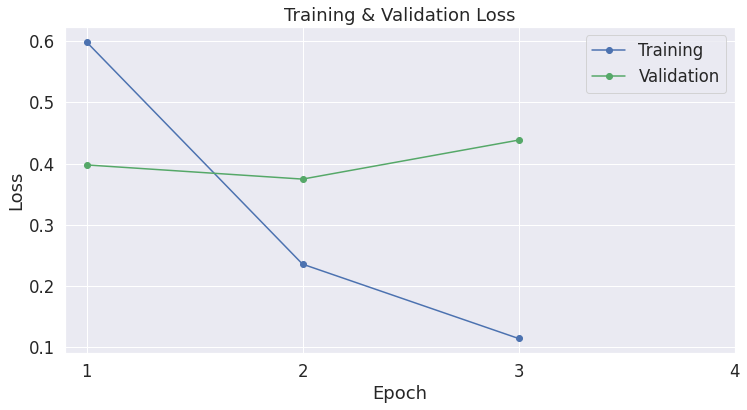

In [61]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Evaluation on Test Set

In [62]:
# Prediction on test set

print("Predicting labels ...")

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(input_ids=b_input_ids,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.extend(logits)
  true_labels.extend(label_ids)

print(f"Predicted {len(predictions)} samples")

Predicting labels ...
Predicted 1028 samples


In [63]:
predictions = np.argmax(predictions, axis=1)
print(f"Test set accuracy: {accuracy_score(true_labels, predictions)}")
print(f"Test set Matthews correlation coefficient: {matthews_corrcoef(true_labels, predictions)}")

Test set accuracy: 0.9105058365758755
Test set Matthews correlation coefficient: 0.8972096756251449


## Save model to disk

In [64]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = f"./{model_name}/"

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving model to {output_dir}")

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./bert-base-german-cased/


('./bert-base-german-cased/vocab.txt',
 './bert-base-german-cased/special_tokens_map.json',
 './bert-base-german-cased/added_tokens.json')

In [66]:
# Mount Google Drive to this Notebook instance.
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
# Copy the model files to a directory in your Google Drive.
target_dir = f"\"./drive/My Drive/NLP/BERT CLF 10kGNAD/\""
!cp -r $output_dir $target_dir

## Load Model from Drive

In [68]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
output_dir = f"./drive/My Drive/NLP/BERT CLF 10kGNAD/{model_name}/"

# Load a trained model and vocabulary that you have fine-tuned
model = AutoModelForSequenceClassification.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

Mounted at /content/drive


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Predict on some sample text

### Prediction

In [0]:
texts = ["Heldt hätte kein Problem damit, wenn es in zwei Wochen in der Bundesliga wieder losgehen würde. „Wir lernen gerade alle, Kompromisse einzugehen, an die wir vor Wochen noch nicht gedacht haben.“ Natürlich seien zehn bis 14 Tage richtiges Mannschaftstraining sinnvoll. „Aber vielleicht kriegen wir diese Zeit nicht. Und dann machen wir es so“, ergänzte der langjährige Manager. Köln-Profi Birger Verstraete hält die Maßnahmen nach den drei positiven Corona-Tests derweil für leichtsinnig. „Wir sollten vorerst nicht unter Quarantäne gestellt werden, und das ist ein bisschen bizarr“, sagte der belgische Mittelfeldspieler dem TV-Sender „VTM“. Beim 1. FC Köln waren zwei Spieler und ein Betreuer positiv auf das Coronavirus getestet worden. „Der Physiotherapeut ist der Mann, der mich und andere Spieler wochenlang behandelt hat. Und mit einem der beiden fraglichen Spieler habe ich am Donnerstag im Fitnessstudio ein Duo gebildet“, sagte Verstraete in dem Interview, über das „Het Laatste Nieuws berichtete."]

In [0]:
input_ids = []
attention_masks = []

for text in texts:
  encoded_dict = tokenizer.encode_plus(
                          text,            
                          add_special_tokens = True,
                          max_length = 64,
                          pad_to_max_length = True,
                          return_attention_mask = True,
                          return_tensors = 'pt')
  
  # Add the encoded sentence to the list.    
  input_ids.append(encoded_dict['input_ids'])

  # And its attention mask (simply differentiates padding from non-padding).
  attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)

In [0]:
# Put model in evaluation mode
model.eval()

predictions = []
last_layer_attentions = []

# Move input ids and attention masks to GPU
input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)

for i in range(len(input_ids)):

  ids = input_ids[i].unsqueeze(0)
  masks = attention_masks[i].unsqueeze(0)

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(input_ids=ids,
                      attention_mask=masks)

  # Get logits and compute softmax
  logits = outputs[0]
  logits = torch.softmax(logits,dim=1)
  last_layer_attention = outputs[1][-1]
  
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  last_layer_attention = last_layer_attention.detach().cpu().numpy()

  last_layer_attentions.append(last_layer_attention)
  predictions.append(logits)

In [72]:
probs = predictions[0][0]
print("text:", texts[0])
print("predictions:", probs)
pred_idx = np.argmax(probs)
print(f"Prediction: {label_names[pred_idx]} ({probs[pred_idx]:.2f})", )

text: Heldt hätte kein Problem damit, wenn es in zwei Wochen in der Bundesliga wieder losgehen würde. „Wir lernen gerade alle, Kompromisse einzugehen, an die wir vor Wochen noch nicht gedacht haben.“ Natürlich seien zehn bis 14 Tage richtiges Mannschaftstraining sinnvoll. „Aber vielleicht kriegen wir diese Zeit nicht. Und dann machen wir es so“, ergänzte der langjährige Manager. Köln-Profi Birger Verstraete hält die Maßnahmen nach den drei positiven Corona-Tests derweil für leichtsinnig. „Wir sollten vorerst nicht unter Quarantäne gestellt werden, und das ist ein bisschen bizarr“, sagte der belgische Mittelfeldspieler dem TV-Sender „VTM“. Beim 1. FC Köln waren zwei Spieler und ein Betreuer positiv auf das Coronavirus getestet worden. „Der Physiotherapeut ist der Mann, der mich und andere Spieler wochenlang behandelt hat. Und mit einem der beiden fraglichen Spieler habe ich am Donnerstag im Fitnessstudio ein Duo gebildet“, sagte Verstraete in dem Interview, über das „Het Laatste Nieuws 

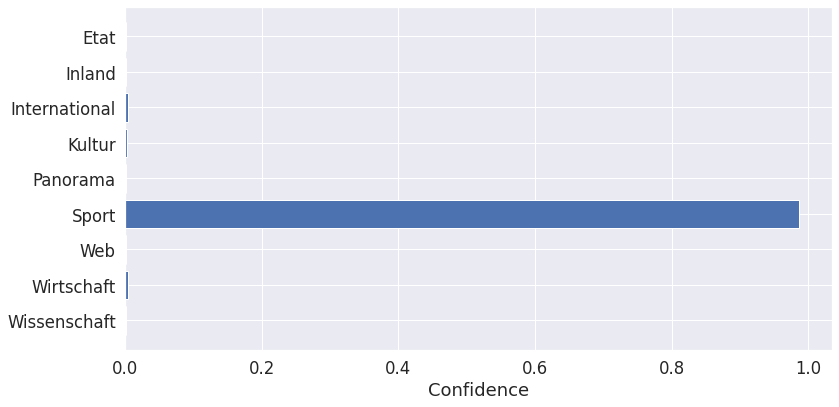

In [73]:
fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(1, 1, 1)

y_pos = np.arange(len(label_names))
confidences = [probs[i] for i in range(len(label_names))]

ax.barh(y_pos, confidences, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(label_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Confidence')

fig.show()

### Visualize Attentions

For each token, visualize the average over all 12 heads of the last layer's attention to the special character [CLS]. The darker the background of the token, the higher its attention

In [0]:
lla = last_layer_attentions[0][0][:,0,:]

In [0]:
def avg_token_attentions(last_layer_attentions):
  return last_layer_attentions.mean(axis=0)

In [0]:
avg_token_atts = avg_token_attentions(lla)
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

In [0]:
def handle_special_token_attentions(tokens, avg_token_atts):
  new_tokens = []
  new_avg_token_atts = []
  for i in range(len(tokens)):
    if tokens[i].startswith("[") or tokens[i].startswith("##"):
      continue
    if i < tokenizer.max_len - 1 and tokens[i+1].startswith("##"):
      merged_tokens = tokens[i] + tokens[i+1][2:]
      atts = [avg_token_atts[i], avg_token_atts[i+1]]
      i += 1
      while i < tokenizer.max_len - 1 and tokens[i+1].startswith("##"):
        merged_tokens += tokens[i+1][2:]
        atts.append(avg_token_atts[i+1])
        i += 1
      new_tokens.append(merged_tokens)
      new_avg_token_atts.append(sum(atts)/len(atts))
    elif i < tokenizer.max_len - 1:
      new_tokens.append(tokens[i])
      new_avg_token_atts.append(avg_token_atts[i])
  new_avg_token_atts = new_avg_token_atts / sum(new_avg_token_atts)
  return new_tokens, new_avg_token_atts

In [0]:
tokens, avg_token_atts = handle_special_token_attentions(tokens, avg_token_atts)

In [79]:
for token, att in zip(tokens, avg_token_atts):
  print(token, att)

Heldt 0.05963272150050977
hätte 0.05842705044356964
kein 0.015847744346937087
Problem 0.01636351010862091
damit 0.013772409461545421
, 0.036807565532129716
wenn 0.03087712355309333
es 0.024819269697866908
in 0.018017946361961145
zwei 0.017895302157496278
Wochen 0.03003063986432607
in 0.025940210667872093
der 0.023251029511036282
Bundesliga 0.05716164042458836
wieder 0.01203980647078767
losgehen 0.00583129451285671
würde 0.03879455071515468
. 0.12072620863387562
Wir 0.019060273146967795
lernen 0.012353933512564218
gerade 0.00628229120688047
alle 0.010505001215702199
, 0.012323023127170943
Kompromisse 0.0056848631707390965
einzugehen 0.002722717941780326
, 0.005047595520602355
an 0.0018329884443071581
die 0.0032613291405828838
wir 0.013254898654295608
vor 0.0036984695310786435
Wochen 0.013122986397435385
noch 0.001867398487968193
nicht 0.0013720230891756517
gedacht 0.0011624416595517478
haben 0.005847323292139942
. 0.0359342915081955
Natürlich 0.0063752301906867415
seien 0.01102179139684

In [0]:
def scale_color_h_hex(c_h, scale):
    return matplotlib.colors.to_hex(
        matplotlib.colors.hsv_to_rgb((c_h, scale, 1)))

def blue_background_hex(scale):
    return scale_color_h_hex(0.625, scale)

In [0]:
att_html = "<table><tr>"
for token, att in zip(tokens, avg_token_atts):
  att_html += "<td>"
  att_html += "<span style=\"background-color: " + blue_background_hex(att) + "\">" + token + "</span>"
  att_html += "</td>"
att_html += "</tr>"

In [82]:
IPython.display.HTML(att_html) 

Heldt,hätte,kein,Problem,damit,",",wenn,es,in,zwei,Wochen,in,der,Bundesliga,wieder,losgehen,würde,.,Wir,lernen,gerade,alle,",",Kompromisse,einzugehen,",",an,die,wir,vor,Wochen,noch,nicht,gedacht,haben,.,Natürlich,seien,zehn,bis,14,Tage,richtiges,Mannschaftstraining,sinnvoll,.,Aber,vielleicht,kriegen,wir,diese
